In [1]:
!wget -O boston_price.csv https://raw.githubusercontent.com/chulminkw/CNN_PG_Torch/refs/heads/main/data/boston_house_price.csv

--2025-06-12 00:43:28--  https://raw.githubusercontent.com/chulminkw/CNN_PG_Torch/refs/heads/main/data/boston_house_price.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39677 (39K) [text/plain]
Saving to: ‘boston_price.csv’

boston_price.csv    100%[===================>]  38.75K  --.-KB/s    in 0.05s   

2025-06-12 00:43:28 (734 KB/s) - ‘boston_price.csv’ saved [39677/39677]



In [2]:
import pandas as pd
import numpy as np

boston_df = pd.read_csv('./boston_price.csv')
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
print(boston_df.shape)

(506, 14)


# W1의 편미분 값
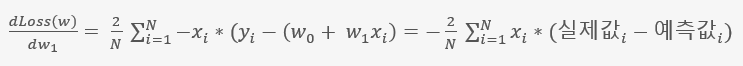

# Bias(절편)의 편미분 값
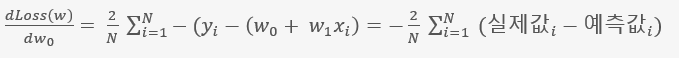

- w1은 RM(방의 계수) 피처의 Weight 값
- w2는 LSTAT(하위계층 비율) 피처의 Weight 값
- bias는 Bias
- N은 입력 데이터 건수

In [10]:
import torch

# gradient_descent()함수에서 반복적으로 호출되면서 update될 weight/bias 값을 계산하는 함수.
# rm은 RM(방 개수), lstat(하위계층 비율), target은 PRICE임. 전체 해당 tensor가 다 입력됨.
# 반환 값은 weight와 bias가 update되어야 할 값과 Mean Squared Error 값을 loss로 반환.
def get_update_weights_value(bias, w1, w2, rm, lstat, target, learning_rate=0.01):
    # 데이터 건수
    N = target.shape[0]
    # print('N타입: ', type(N)) -> <class 'int'>

    # 예측 값. weight * feature
    predicted = w1 * rm + w2 * lstat + bias
    # print('predicted 타입: ', type(predicted)) -> <class 'torch.Tensor'>

    # 실제값과 예측값의 차이
    diff = target - predicted
    # print('diff 타입: ', type(diff)) -> <class 'torch.Tensor'>

    # weight와 bias를 얼마나 update할 것인지를 계산.
    w1_update = -(2/N) * learning_rate * (torch.matmul(rm, diff)) # (torch.dot(rm, diff))
    w2_update = -(2/N) * learning_rate * (torch.matmul(lstat, diff))
    bias_update = -(2/N) * learning_rate * torch.sum(diff)

    # Mean Squared Error값을 계산. -> 실제값과 예측값의 차이를 제곱해서 평균
    mse_loss = torch.mean(diff ** 2)

    # weight와 bias가 update되어야 할 값과 Mean Squared Error 값을 반환.
    return bias_update, w1_update, w2_update, mse_loss

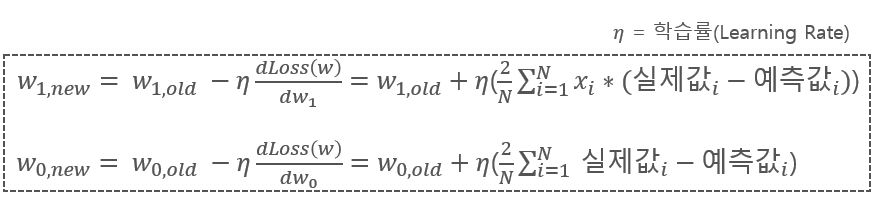

### Gradient Descent 를 적용하는 함수 생성
* iter_epochs 수만큼 반복적으로 get_update_weights_value()를 호출하여 update될 weight/bias값을 구한 뒤 Weight/Bias를 Update적용.

In [13]:
# RM, LSTAT feature tensor와 PRICE target tensor를 입력 받아서,
# iter_epochs수만큼 반복적으로 Weight와 Bias를 update적용.
def gradient_descent(features, target, iter_epochs=1000, learning_rate=0.01, verbose=True):
    # w1, w2는 1차원 tensor로 변환하되 초기 값은 0으로 설정
    # bias도 1차원 tensor로 변환하되 초기 값은 1로 설정.
    w1 = torch.zeros(1, dtype=torch.float32) # 1차원
    w2 = torch.zeros(1, dtype=torch.float32)
    bias = torch.ones(1, dtype=torch.float32)

    print('최초 w1, w2, bias:', w1.item(), w2.item(), bias.item()) # tensor 값 확인

    # learning_rate와 RM, LSTAT 피처 지정.
    # 호출 시 tensor형태로 RM과 LSTAT으로 된 2차원 feature가 입력됨.
    rm = features[:, 0]
    lstat = features[:, 1]

    # iter_epochs 수만큼 반복하면서 weight와 bias update 수행.
    for i in range(1, iter_epochs+1):
        # weight/bias update 값 계산
        bias_update, w1_update, w2_update, loss = get_update_weights_value(bias, w1, w2, rm, lstat, target, learning_rate=0.01)

        # weight/bias의 update 적용.
        w1 = w1 - w1_update
        w2 = w2 - w2_update
        bias = bias - bias_update

        if verbose: # 10회 epochs 시마다 출력
            if i % 100 == 0:
                print(f'Epoch: {i}/{iter_epochs}')
                print(f'w1: {w1.item()}, w2: {w2.item()}, bias: {bias.item()}, loss: {loss.item()}')

    return w1, w2, bias

### Gradient Descent 적용
* 신경망은 데이터를 정규화/표준화 작업을 미리 선행해 주어야 함.
* 이를 위해 사이킷런의 MinMaxScaler를 이용하여 개별 feature값은 0~1사이 값으로 변환후 학습 적용.

In [14]:
import torch
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features_np = scaler.fit_transform(boston_df[['RM', 'LSTAT']])

scaled_features_ts = torch.from_numpy(scaled_features_np)
targets_ts = torch.from_numpy(boston_df['PRICE'].values)

w1, w2, bias = gradient_descent(scaled_features_ts, targets_ts, iter_epochs=5000, verbose=True)
print('##### 최종 w1, w2, bias #######')
print(w1.item(), w2.item(), bias.item())

최초 w1, w2, bias: 0.0 0.0 1.0
Epoch: 100/5000
w1: 9.269001960754395, w2: 1.848307490348816, bias: 15.784483909606934, loss: 76.57334085917176
Epoch: 200/5000
w1: 11.12940502166748, w2: -0.26894235610961914, bias: 16.718103408813477, loss: 66.99356210609766
Epoch: 300/5000
w1: 12.410794258117676, w2: -2.4306209087371826, bias: 16.78126335144043, loss: 60.657992415148215
Epoch: 400/5000
w1: 13.5518159866333, w2: -4.4094438552856445, bias: 16.7880916595459, loss: 55.42883628978056
Epoch: 500/5000
w1: 14.5894136428833, w2: -6.2080607414245605, bias: 16.789827346801758, loss: 51.10775152132247
Epoch: 600/5000
w1: 15.534501075744629, w2: -7.842007637023926, bias: 16.789838790893555, loss: 47.53698282844233
Epoch: 700/5000
w1: 16.395551681518555, w2: -9.326227188110352, bias: 16.788480758666992, loss: 44.58622729642974
Epoch: 800/5000
w1: 17.180194854736328, w2: -10.67434310913086, bias: 16.78590965270996, loss: 42.14781261961288
Epoch: 900/5000
w1: 17.895353317260742, w2: -11.898761749267578,

### 계산된 Weight와 Bias를 이용하여 Price 예측
* 예측 feature 역시 0~1사이의 scaled값을 이용하고 Weight와 bias를 적용하여 예측값 계산.

In [15]:
predicted = scaled_features_ts[:, 0]*w1 + scaled_features_ts[:, 1]*w2 + bias
boston_df['PREDICTED_PRICE'] = predicted.cpu().numpy()
boston_df.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE,PREDICTED_PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,28.948606
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,25.489461
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,32.538213
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4,32.337287
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2,31.506543
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7,28.092617
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9,21.354932
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1,17.757951
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5,8.102840
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9,18.274740


# MSE 적용

In [16]:
from sklearn.metrics import mean_squared_error

total_mse = mean_squared_error(boston_df['PRICE'], boston_df['PREDICTED_PRICE'])
print(total_mse)

30.529068392718102


## 학습, 훈련 데이터 분리

In [17]:
from sklearn.model_selection import train_test_split

tr_features, test_features, tr_target, test_target = train_test_split(scaled_features_np, boston_df['PRICE'].values,
                                                                      test_size=0.3, random_state=2025)
print(tr_features.shape, tr_target.shape, test_features.shape, test_target.shape)

(354, 2) (354,) (152, 2) (152,)


In [18]:
tr_features_ts = torch.from_numpy(tr_features)
tr_targets_ts = torch.from_numpy(tr_target)

w1, w2, bias = gradient_descent(tr_features_ts, tr_targets_ts, iter_epochs=5000, verbose=True)
print('##### 최종 w1, w2, bias #######')
print(w1.item(), w2.item(), bias.item())

최초 w1, w2, bias: 0.0 0.0 1.0
Epoch: 100/5000
w1: 9.339546203613281, w2: 1.8875619173049927, bias: 15.797615051269531, loss: 78.9614608353271
Epoch: 200/5000
w1: 11.224658966064453, w2: -0.2506784200668335, bias: 16.722768783569336, loss: 69.22029253595441
Epoch: 300/5000
w1: 12.530157089233398, w2: -2.4354617595672607, bias: 16.78445053100586, loss: 62.722031823449456
Epoch: 400/5000
w1: 13.693787574768066, w2: -4.437812805175781, bias: 16.791311264038086, loss: 57.34695699495645
Epoch: 500/5000
w1: 14.752245903015137, w2: -6.260195255279541, bias: 16.79372215270996, loss: 52.89595114958271
Epoch: 600/5000
w1: 15.716482162475586, w2: -7.917947769165039, bias: 16.794925689697266, loss: 49.210115801603116
Epoch: 700/5000
w1: 16.595050811767578, w2: -9.425844192504883, bias: 16.795217514038086, loss: 46.15790295077578
Epoch: 800/5000
w1: 17.395660400390625, w2: -10.797380447387695, bias: 16.794694900512695, loss: 43.63037503736381
Epoch: 900/5000
w1: 18.125289916992188, w2: -12.0448436737

In [19]:
test_features_ts = torch.from_numpy(test_features)
test_predicted_ts = test_features_ts[:, 0]*w1 + test_features_ts[:, 1]*w2 + bias

boston_test_df = pd.DataFrame({
    'RM': test_features[:, 0],
    'LSTAT': test_features[:, 1],
    'PRICE': test_target,
    'PREDICTED_PRICE': test_predicted_ts.cpu().numpy()
})

boston_test_df.head(20)

,RM,LSTAT,PRICE,PREDICTED_PRICE
0,0.504311,0.546082,11.0,16.276481
1,0.727534,0.082781,31.5,33.224345
2,0.442422,0.348786,22.0,19.469608
3,0.443380,0.197296,50.0,23.164367
4,0.519640,0.139349,24.1,26.523540
5,0.511401,0.309051,20.1,22.200871
6,0.425752,0.450607,22.5,16.575347
7,0.612569,0.049669,32.4,31.078924
8,0.623683,0.061258,31.6,31.083084
9,0.571757,0.533940,10.9,18.299919


In [20]:
test_total_mse = mean_squared_error(boston_test_df['PRICE'], boston_test_df['PREDICTED_PRICE'])
print(test_total_mse)

28.44255102479557
